<a href="https://colab.research.google.com/github/engineerjkk/Deep_Learning/blob/main/28.%5BGAN%5DFaceGenerater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN 에서 트레이닝까지 필요한 최종 코드  
- 이미지 5만개 전처리해서 X데이터 만드는 부분  
- Generator, Discriminator 모델 만드는 부분  
- GAN 모델 만들고 Compile 하는 부분   

캐글에서 이미지를 다운받습니다. 1.32G정도 되는군요 그리고 압축을 풀어줍니다. 
물론 캐글홈페이지가서, json 파일을 다운받아 구글 드라이브  "drive/MyDrive/Colab Notebooks/"  링크에 있어야합니다.

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "drive/MyDrive/Colab Notebooks/" 
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip -d .

 99% 1.32G/1.33G [00:35<00:00, 30.6MB/s]
100% 1.33G/1.33G [00:35<00:00, 40.3MB/s]


구글 드라이브 마운트하기 만약 안되면 이거 실행하고 하세요.
>from google.colab import drive  
>drive.mount('/content/drive')

In [31]:
#이미지 처리 라이브러리
from PIL import Image
!pip install Pillow

이미지 5만개를 images 리스트에 담아주도록 합니다. crop을 이용하여 얼굴만 짤라낼 것이며, 시간절약을 위해 convert('L')을 합니다. 컬러로 하고싶으면 저거 필어없어요 그리고 size는 64by64 픽셀로 수행합니다. 한번 images 리스트에 담긴 사진 한장을 살펴보죠

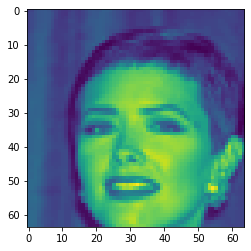

(50000, 64, 64)


In [32]:


import os
import numpy as np
#폴더내부의 모든 파일명을 [리스트]에 담아줍니다.
FileList=os.listdir('/content/img_align_celeba/img_align_celeba')
images=[]
#가장자리만 남겨주세요는 crop
#시간절약을 위해 흑백으로 해 봅시다.
#.convert('L')
for i in FileList[0:50000]:
  Num_Image=Image.open('/content/img_align_celeba/img_align_celeba/'+i).crop((20,30,160,180)).convert('L').resize((64,64))
  images.append(np.array(Num_Image))

import matplotlib.pyplot as plt
plt.imshow(images[1])
plt.show()

images=np.array(images)
print(images.shape)

255로 나눠 정규화 시켜줄거에요 0~1사이로 만들거거든요. 이거 한번만 실행시키세요. 안그러면 계속나눠집니다. 아. 그리고 CNN이 내부 구조인데, CNN은 4차원 구조인거 아시죠? 근데 그레이 스케일이라서 3차원이니  rashape으로 4차원으로 늘려줍니다.

In [33]:
#225로 나눠봅시다. 한번만 실행시키세요
images=np.divide(images,255)
#CNN는 4차원 행렬이어야 가능합니다.
images=images.reshape(50000,64,64,1)
print(images.shape)

(50000, 64, 64, 1)


from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Dropout, Flatten, Conv2D, Conv2DTranspose,BatchNomalization

이제 Generator와 Discriminator를 만들어봅시다.  
Discriminator : 이미지를 입력했을때 진짜인지 가짜인지 출력하는 모델입니다.  
input : 이미지이며, output은 0또는 1이나 확률입니다.   
이제 Generator와 Discriminator를 만들어봅시다.

In [34]:
import tensorflow as tf 


discriminator = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64,1]),
  #activation 함수를 밑으로 뺍니다. GAN에서는 LeakyReLU가 좋다고 하네요 
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  #하나를 내뱉으니 마지막 node는 1개
  tf.keras.layers.Dense(1, activation='sigmoid')
]) 

랜덤숫자 100개를 넣으면 이미지 1개를 퉤 뱉습니다. 이게 곧 Generator 만드는 것이죠

In [35]:
noise_shape=100

generator = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4 * 4 * 256, input_shape=(100,) ), 
  tf.keras.layers.Reshape((4, 4, 256)),
  #Upsampling
  tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')
])

generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 256)         590080    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)      

1.discriminator 트레이닝  
2.generator 트레이닝  
(generator는 GAN 전체 써서 트레이닝 합니다.)  
3.그래서 GAN을 컴파일 하겠습니다.  
GAN 전체 모델을 만듭니다.

첫번째 discriminator 트레이닝을 할 때, 그 다음에 generator를 트레이닝 할 때 GAN 에다가 집어넣습니다. 그때 discriminator는 트레이닝이 되면 안됩니다. 그냥 구분 기계 역할만 해야합니다.

In [36]:
#GAN
GAN=tf.keras.models.Sequential([generator,discriminator])

discriminator.compile(optimizer='adam',loss='binary_crossentropy')

discriminator.trainable=False #discriminator는 트레이닝 하지말아주세요.

GAN.compile(optimizer='adam',loss='binary_crossentropy')

내가 원하는 값을 균일하게 뽑아줍니다 범위는 -1 ~ 1까지 균일하게입니다.  
100개 숫자를 10세트 뽑아주세요

In [37]:
def predict_pic():
  랜덤숫자=np.random.uniform(-1,1,size=(10,100)) 
  예측=generator.predict(랜덤숫자) 
  #print(예측)
  print(예측.shape)
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(예측[i].reshape(64,64), cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()


discriminater트레이닝하고 generator 트레이닝 할건데, 그거 GAN이며 GAN을 이용해서 트레이닝 할 것입니다.  

discriminator.train_on_batch(진짜사진50장,1로마킹한 정답들(50개))  
discriminator.train_on_batch(가짜사진50장,0으로 마킹은 정답들(50개))  

그럼이제 4개의 변수들이 필요하겠죠?


#discriminator 트레이닝  
# Generator 트레이닝  
GAN에 랜덤숫자, 정답1을 128개 집어넣으면 끝입니다.
5만장 다 쓰는게 epoch 1회입니다. epoch를 여러번 돌려보겠습니다.

이번 epoch의 최종 loss는 Discriminator1.188683569431305 GAN 1.9795525074005127
지금 epoch 몇회냐면 146
(10, 64, 64, 1)


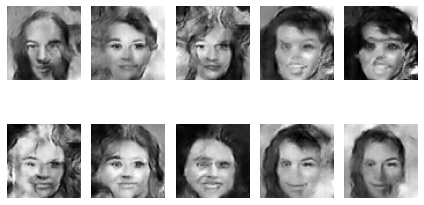

지금 몇번째 batch냐면0
지금 몇번째 batch냐면100


KeyboardInterrupt: ignored

In [38]:
x데이터 = images
for j in range(300):
  print(f'지금 epoch 몇회냐면 {j}') #f : 글자 중간에 {변수} 넣기 신 문법데이터 = images
  predict_pic()
  #Discriminator 트레이닝데이터 = images
  for i in range(50000//128):
    if i%100==0:
      print(f'지금 몇번째 batch냐면{i}')
      
    #Discriminator 트레이닝
    진짜사진들=x데이터[i*128:(i+1)*  128]
    마킹한정답들1=np.ones(shape=(128,1))
    loss1=discriminator.train_on_batch(진짜사진들,마킹한정답들1)

    랜덤숫자=np.random.uniform(-1,1,size=(128,100))
    가짜사진들=generator.predict(랜덤숫자)
    마킹한정답들0=np.zeros(shape=(128,1))
    loss2=discriminator.train_on_batch(가짜사진들,마킹한정답들0)

    #Generator 트레이닝
    랜덤숫자=np.random.uniform(-1,1,size=(128,100))
    마킹한정답들1=np.ones(shape=(128,1))

    loss3=GAN.train_on_batch(랜덤숫자,마킹한정답들1)

  print(f'이번 epoch의 최종 loss는 Discriminator{loss1+loss2} GAN {loss3}') 
